In [1]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [2]:
import pandas as pd
import numpy as np
import utils as uti

In [3]:
# Path to the uploaded CSV file and upload it
file_path = './data/WA_disciplinary_actions.csv'
df = pd.read_csv(file_path)

# Keep only: 'Description' and those starting with 'conduct'
conduct_cols = [col for col in df.columns if col.startswith('conduct')]
cols_to_keep = ['Description'] + conduct_cols
df = df[cols_to_keep]

# Remove rows with no labels (conducts) and no description
df_filtered = df.dropna(how='all', subset=conduct_cols)
df_filtered = df_filtered.dropna(subset=['Description'])
percentage_kept = (len(df_filtered) / len(df)) * 100
print(f"Percentage of samples kept: {percentage_kept:.2f}%")
df_filtered

Percentage of samples kept: 69.48%


,Description,conduct1,conduct2,conduct3,conduct4,conduct5,conduct6,conduct7,conduct8,conduct9,conduct10,conduct11,conduct12,conduct13,conduct14,conduct15
0,"John A. Walsh (WSBA No. 20603, admitted 1991),...",Fairness to Opposing Party and Counsel,Conduct Prejudicial to the Administration of J...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"Louis A. Ferreira (WSBA No. 20646, admitted 19...",Scope of Representation,Conflict of Interest,Conflict of Interest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,"Roland O. Foster Balloun (WSBA No. 20884, admi...",Competence,Preserving Identity of Funds and Property of a...,Declining or Terminating Representation,Conflict of Interest,Conflict of Interest,Candor Toward the Tribunal,Fairness to Opposing Party and Counsel,Respect for Rights of Third Person,"Dishonesty, Fraud, Deceit or Misrepresentation",Conduct Prejudicial to the Administration of J...,Violate ELCs,NaN,NaN,NaN,NaN
20,"Thomas G. Batson (WSBA No. 20888, admitted 199...",Preserving Identity of Funds and Property of a...,"Dishonesty, Fraud, Deceit or Misrepresentation",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,"Kevin G. Healy (WSBA No. 16307, admitted 1986)...",Conflict of Interest,Conflict of Interest,"Dishonesty, Fraud, Deceit or Misrepresentation",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,"Brad A. Plumb (WSBA No. 20337, admitted 1991),...",Candor Toward the Tribunal,Criminal Act,"Dishonesty, Fraud, Deceit or Misrepresentation",Moral Turpitude,Violate Oath of Attorney,Conduct Demonstrating Unfitness to Practice Law,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1239,"Clinton L. Morgan (WSBA No. 22181, admitted 19...",Conflict of Interest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1240,"Stephen B. Blanchard (WSBA No. 12294, admitted...",Competence,Preserving Identity of Funds and Property of a...,Scope of Representation,Diligence,Communication,Fees,Expediting Litigation,"Dishonesty, Fraud, Deceit or Misrepresentation",Violate ELCs,NaN,NaN,NaN,NaN,NaN,NaN
1241,"Mark Stansfield (WSBA No. 11356, admitted 1980...",Scope of Representation,Conflict of Interest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Preprocess Labels (conduct)

In [151]:
#Get all the unique labels (conduct violations)
unique_conducts = np.sort(pd.Series(df_filtered[conduct_cols].values.ravel()).dropna().unique())
print((unique_conducts), len(unique_conducts))

['Advertising' 'Advisor' 'Bar Admission Matters'
 'Candor Toward the Tribunal' 'Client with Disability/Dimished Capacity'
 'Communication' 'Communication with Person. Represented by Counsel'
 'Communications concerning a Lawyers Services' 'Competence'
 'Conduct Demonstrating Unfitness to Practice Law'
 'Conduct Prejudicial to the Administration of Justice' 'Confidentiality'
 'Conflict of Interest' 'Criminal Act'
 'Declining or Terminating Representation' 'Diligence'
 'Direct Contact with Prospective Clients'
 'Dishonesty, Fraud, Deceit or Misrepresentation' 'Disobey Court Order'
 'Duties to Former Clients' 'Expediting Litigation'
 'Fairness to Opposing Party and Counsel' 'Fees'
 'Firm Names and Designations' 'Impartiality and Decorum of the Tribunal'
 'Improperly Influence a Governmental Official'
 'Imputed Disqualification; General Rule' 'Judicial and Legal Officials'
 'Meritorious Claims and Contentions' 'Misconduct'
 'Misconduct Involving Disbarred, Suspended, Resigned, or Inactive 

### Preprocess Descriptions

In [154]:
# Preprocess data by converting text to lowercase, removing non-word characters and numbers, 
# excluding the specific word 'wsba', exclude single characters, tokenizing, removing stopwords, and applying lemmatization or stemming if method = "stemming"
preprocessor = uti.TextPreprocessor(method='lemmatization')
preprocessed_descriptions = df_filtered['Description'].apply(preprocessor.preprocess)
preprocessed_descriptions

872

### Classification using logistic regression

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [186]:
scores = []
freq_label = []

for label in unique_conducts:
    mask = df_filtered[conduct_cols].isin([label])
    index_with_label = df_filtered[mask].dropna(how='all').index.values.tolist()
    index_without_label = np.setdiff1d(np.array(preprocessed_descriptions.index),np.array(index_with_label))
    freqency = len(index_with_label)/len(preprocessed_descriptions)
    freq_label.append(freqency)
    df_labels = pd.DataFrame(np.append(np.ones(len(index_with_label)), np.zeros(len(index_without_label))),index = np.append(index_with_label, index_without_label))
    
    # descriptions_with_label = preprocessed_descriptions.loc[index_with_label]
    # descriptions_without_label = preprocessed_descriptions.drop(index_with_label)

    # split into test and train (check that every class is presented)
    y_train = [1]
    while np.sum(y_train) == len(y_train):
        x_train, x_test, y_train, y_test = train_test_split(preprocessed_descriptions.values,df_labels.values,test_size=0.2)

    # vectorize the train and test descriptions
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_train_vectors = tfidf_vectorizer.fit_transform(x_train)
    tfidf_test_vectors = tfidf_vectorizer.transform(x_test)

    # run logistic regression on train data
    logreg=LogisticRegression()
    logreg.fit(tfidf_train_vectors,np.ravel(y_train))

    # estimate the accuracy of the model
    scores.append(logreg.score(tfidf_test_vectors, y_test))

### Accuracy estimation of the model

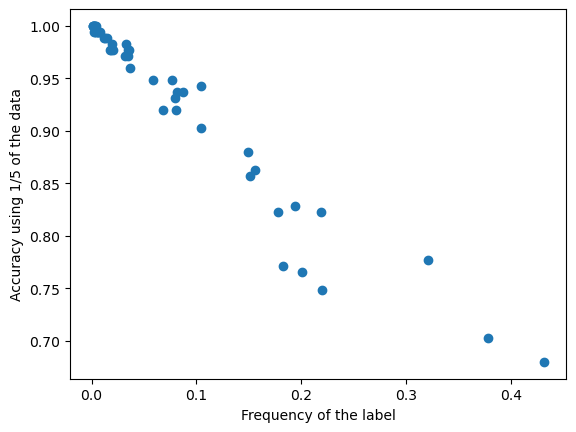

In [188]:
import matplotlib.pyplot as plt
plt.plot(freq_label, scores,'o')
plt.ylabel("Accuracy using 1/5 of the data")
plt.xlabel("Frequency of the label")
plt.show()